In [ ]:
import requests
import os

# 1. Twój oryginalny link
ORIGINAL_LINK = "https://www.dropbox.com/scl/fo/zt8vm2nkekxe1ci0igmyw/ANWXllOA2sBymobkeigHYtg?rlkey=2rcc3o2kqrarmuo8xlofl37yu&st=xgn3p55p&dl=0"

# 2. Konwersja na link do pobrania (USUŃ parametry rlkey i st)
DOWNLOAD_LINK = ORIGINAL_LINK \
    .replace("www.dropbox.com/scl/fo", "dl.dropboxusercontent.com/scl/fi") \
    .replace("?rlkey=2rcc3o2kqrarmuo8xlofl37yu&st=xgn3p55p&dl=0", "?dl=1")

# 3. Pobieranie
try:
    response = requests.get(DOWNLOAD_LINK, stream=True)
    response.raise_for_status()  # Sprawdź status
    
    # 4. Zapisz plik
    filename = "downloaded_file"  # lub wyciągnij z headers
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            
    print(f"Pobrano plik jako: {filename}")

except Exception as e:
    print(f"Błąd {e}")
    print("""
    Rozwiązania:
    1. Wygeneruj nowy link (prawy przycisk → Udostępnij → Kopiuj link)
    2. Upewnij się że link jest publiczny
    3. Dla folderów użyj API Dropbox
    """)

Błąd: 404 Client Error: Not Found for url: https://dl.dropboxusercontent.com/scl/fi/zt8vm2nkekxe1ci0igmyw/ANWXllOA2sBymobkeigHYtg?rlkey=2rcc3o2kqrarmuo8xlofl37yu&st=xgn3p55p?dl=1

    Rozwiązania:
    1. Upewnij się, że link jest publicznie dostępny
    2. Spróbuj wygenerować nowy link (prawy przycisk → Udostępnij → Kopiuj link)
    3. Dla folderów lepiej użyć API Dropbox
    


In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("volkandl/car-brand-logos")

print("Path to dataset files:", path)

Path to dataset files: /home/jan/.cache/kagglehub/datasets/volkandl/car-brand-logos/versions/1


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys

In [21]:
class CarsDataset(Dataset):
    def __init__(self, data_dir : str, transform=None) -> None: 
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx : int):
        return self.data[idx]
        
    @property
    def classes(self):
        return self.data.classes
    

In [22]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = path + '/Car_Brand_Logos/Train'

dataset = CarsDataset(
    data_dir,
    transform
)

In [23]:
image, label = dataset[1]
print(label, len(dataset))
dataset.classes

0 2513


['hyundai',
 'lexus',
 'mazda',
 'mercedes',
 'opel',
 'skoda',
 'toyota',
 'volkswagen']

In [24]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
class CarClassifer(nn.Module):
    def __init__(self, num_classes=8):
        super(CarClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [26]:
model = CarClassifer(num_classes=8)


In [27]:
for images, labels in train_loader:
    break

In [28]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 8])

In [29]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 8]) torch.Size([32])


In [31]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_dataset = path + '/Car_Brand_Logos/Test'

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CarClassifer(num_classes=8)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}")

Epoch 1/5 - Train loss: 0.8280146972524944
Epoch 2/5 - Train loss: 0.3780692170162482
Epoch 3/5 - Train loss: 0.2424946783360285
Epoch 4/5 - Train loss: 0.2091291040431158
Epoch 5/5 - Train loss: 0.1241658151289096


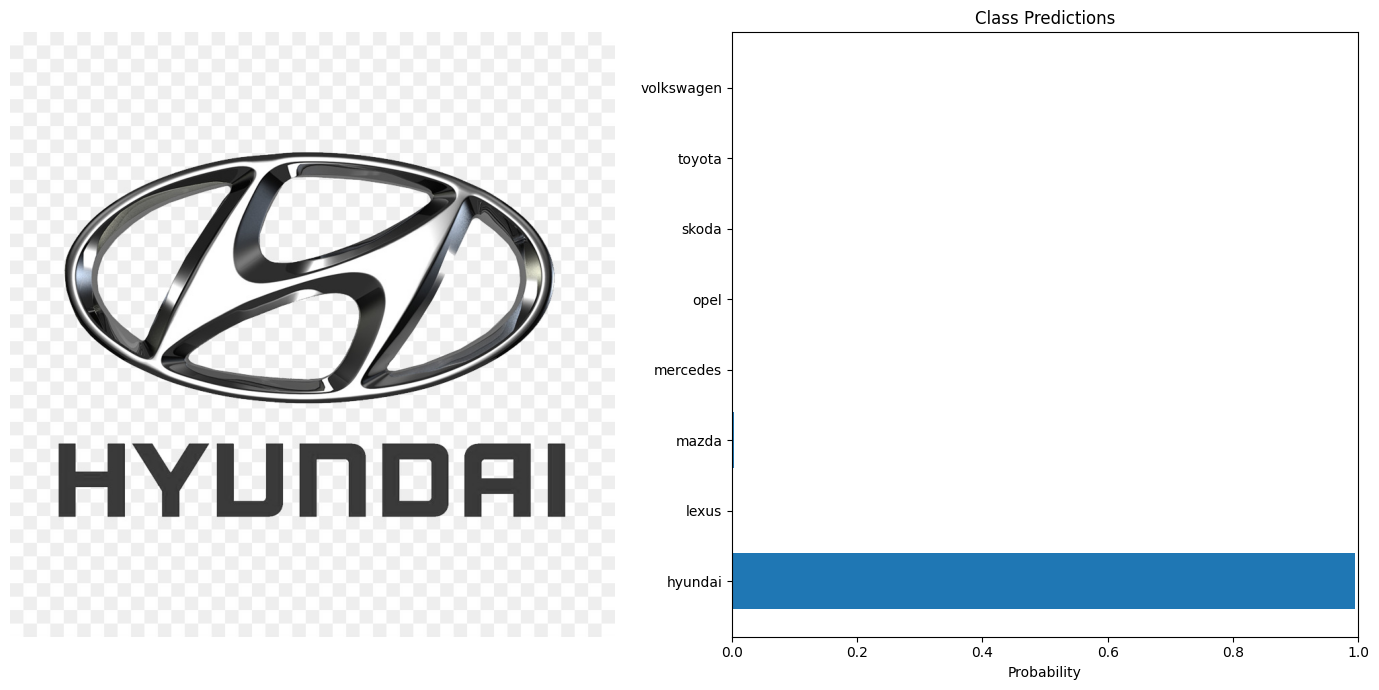

In [33]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/home/jan/.cache/kagglehub/datasets/volkandl/car-brand-logos/versions/1/Car_Brand_Logos/Test/hyundai/-car-hyundai-i30-hyundai-tucs-car-logo-5ad2754300c7e0.8761883915237420190032.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

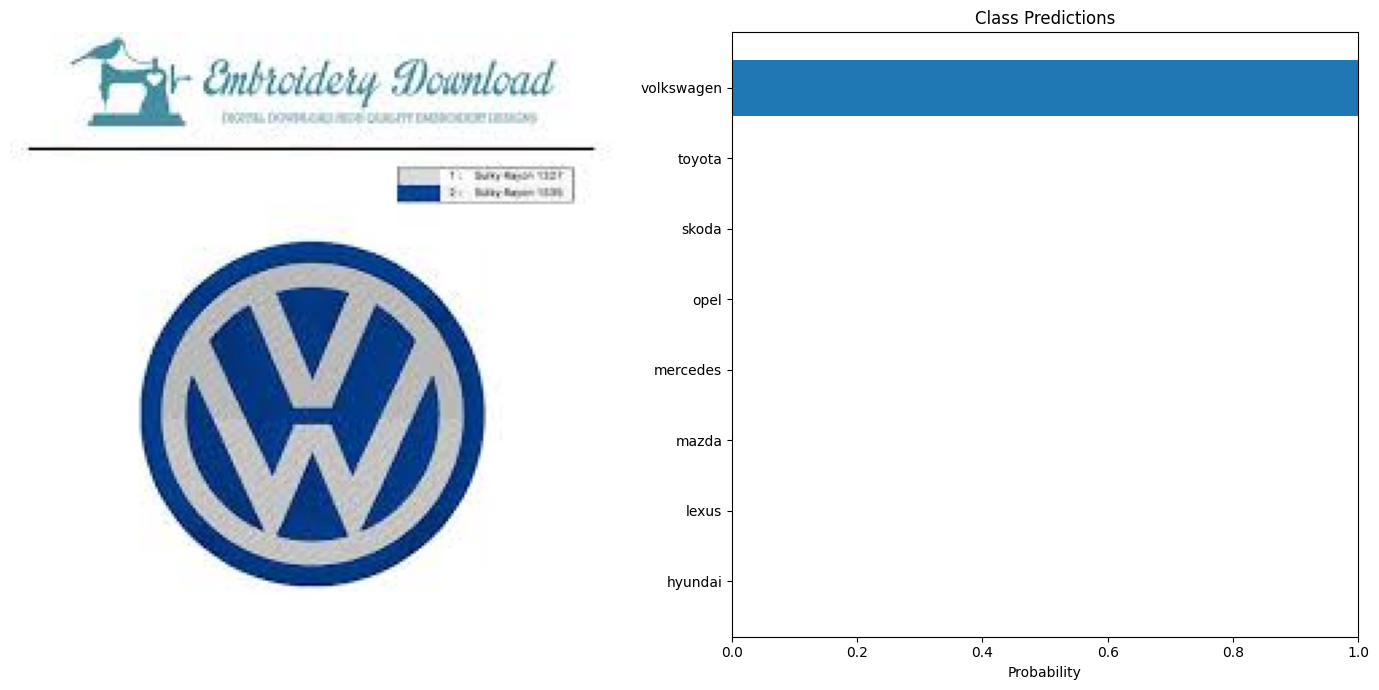

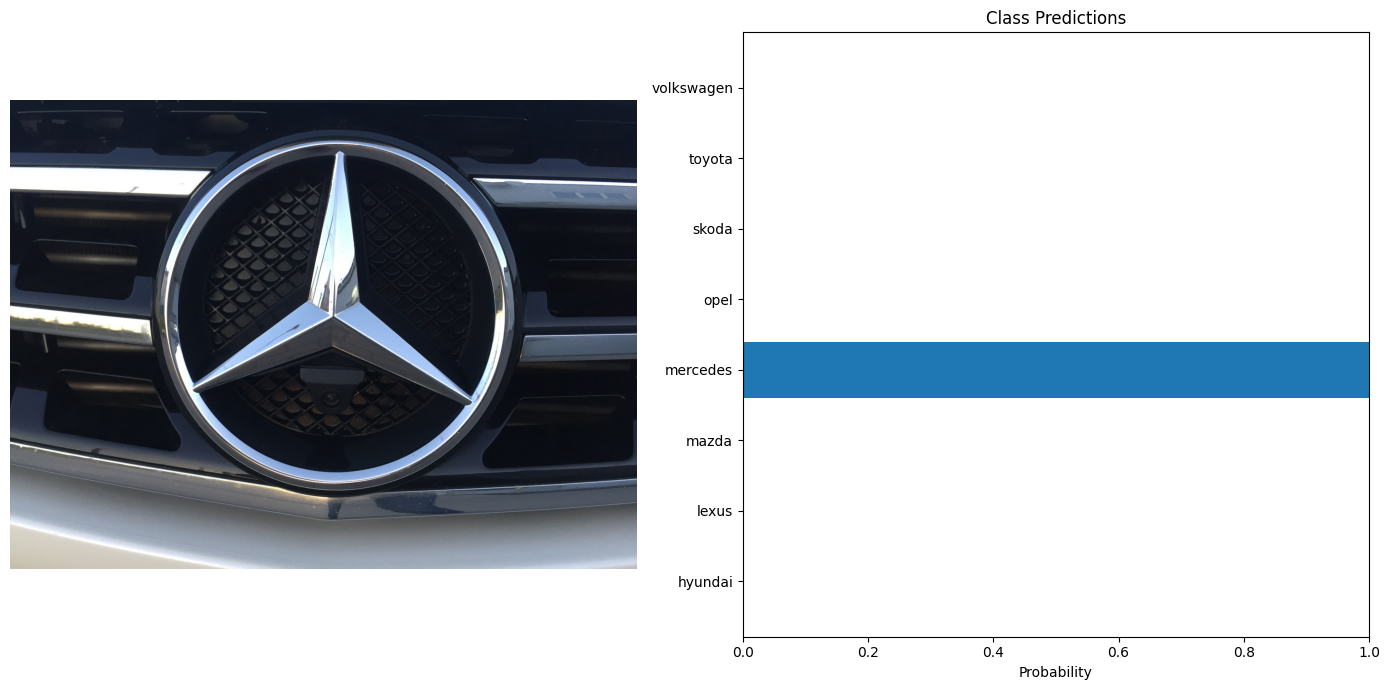

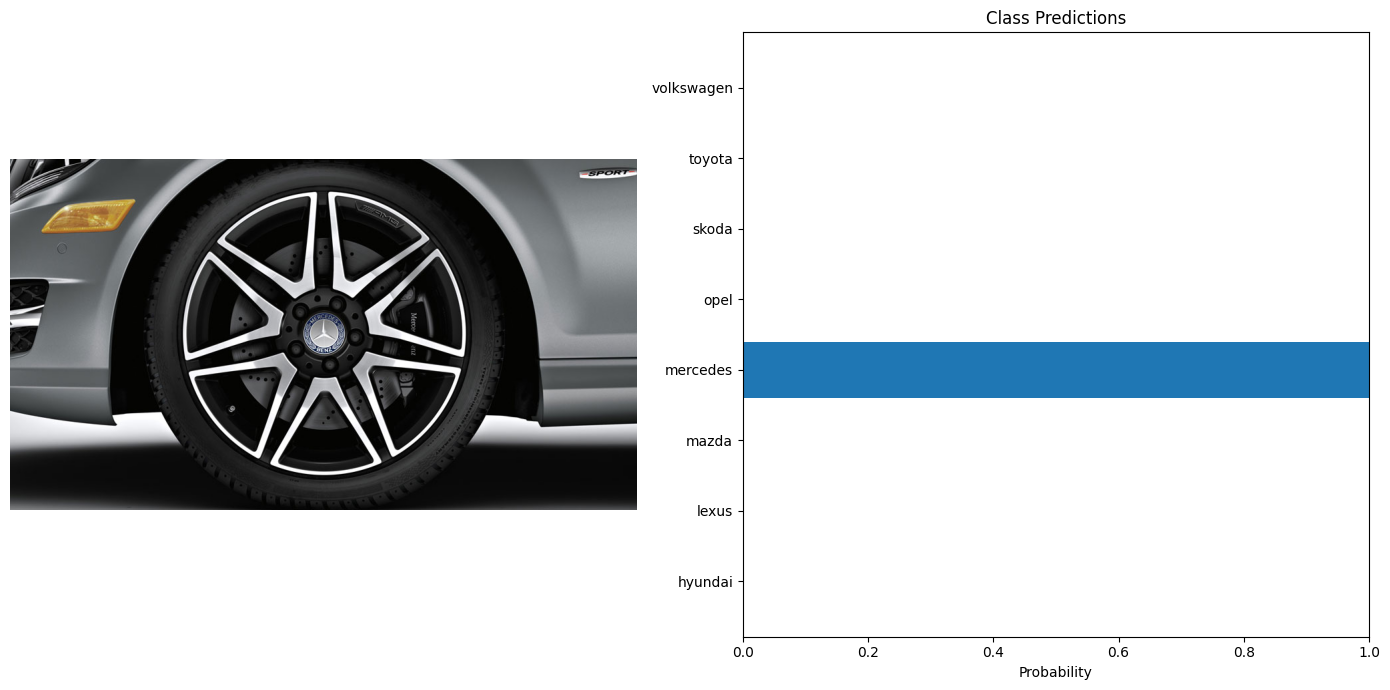

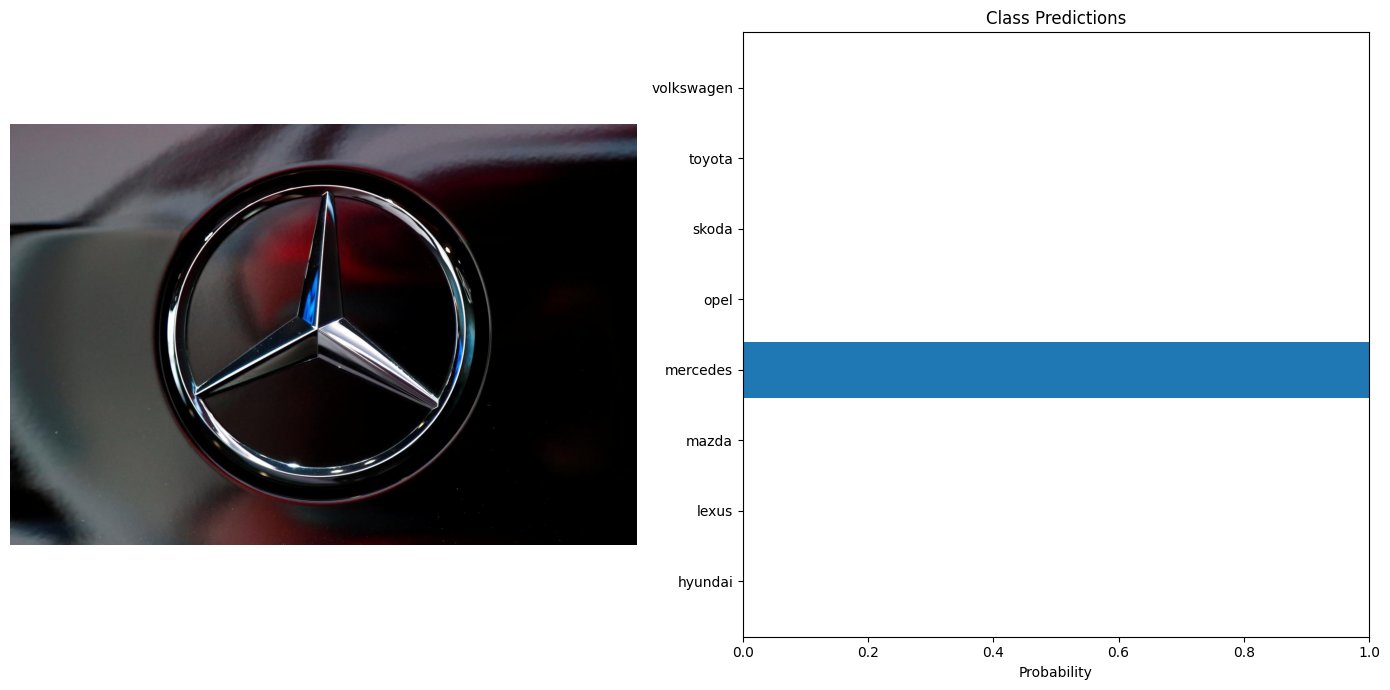

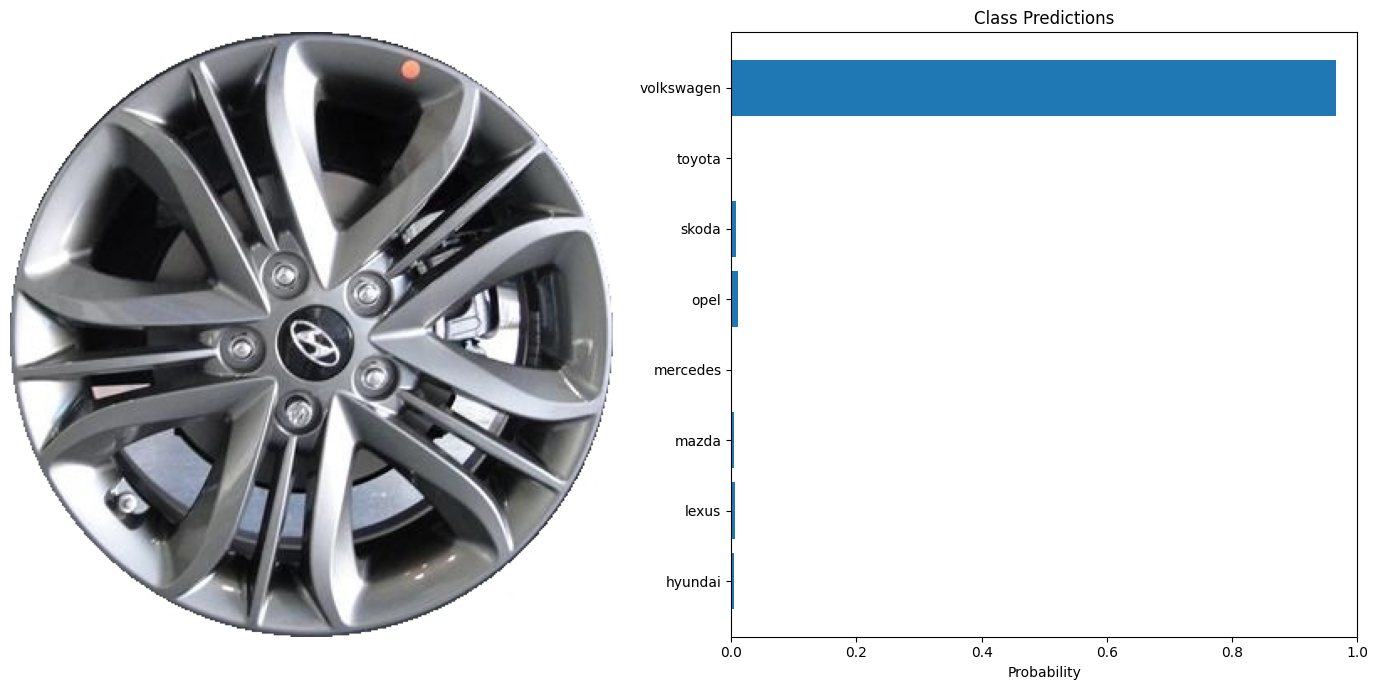

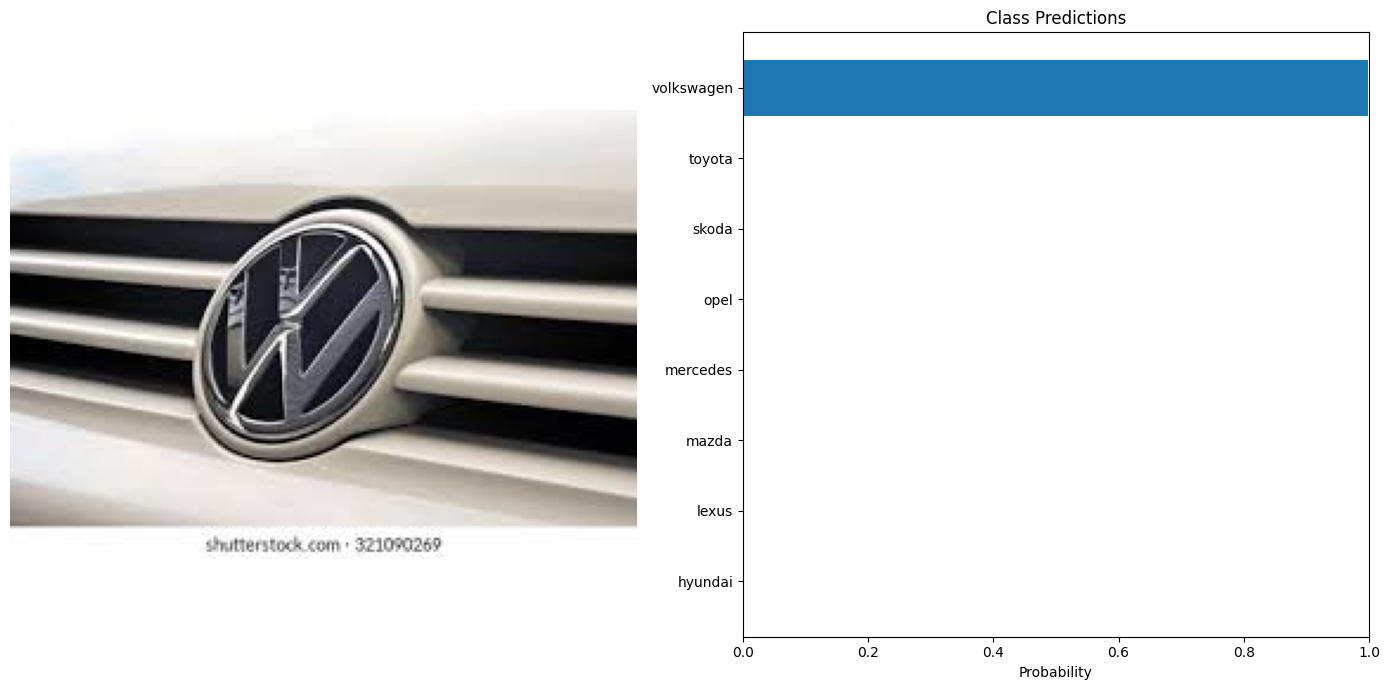

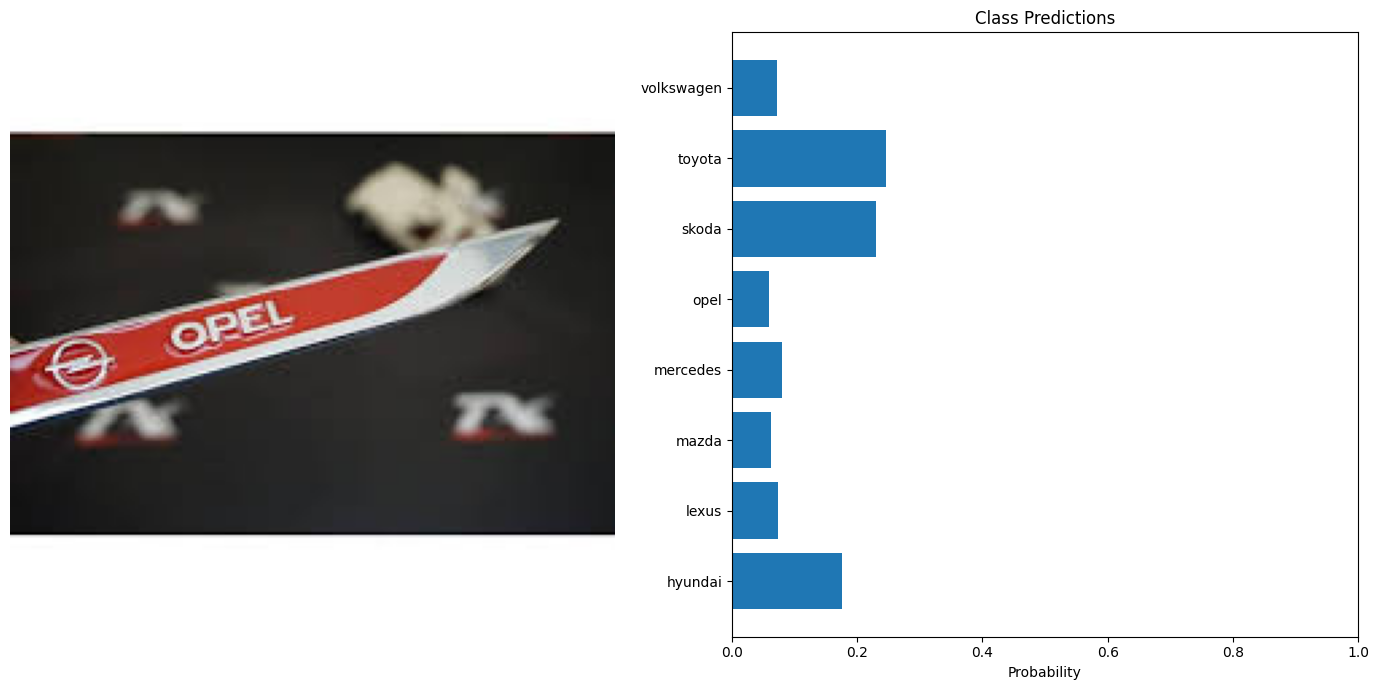

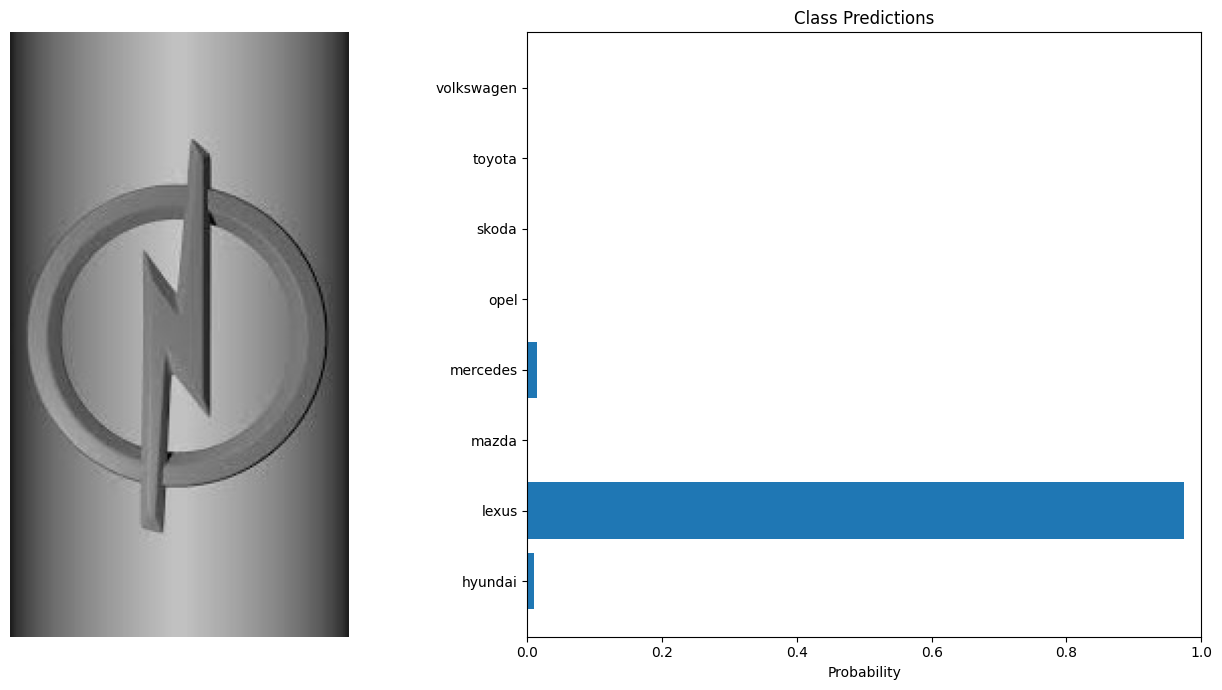

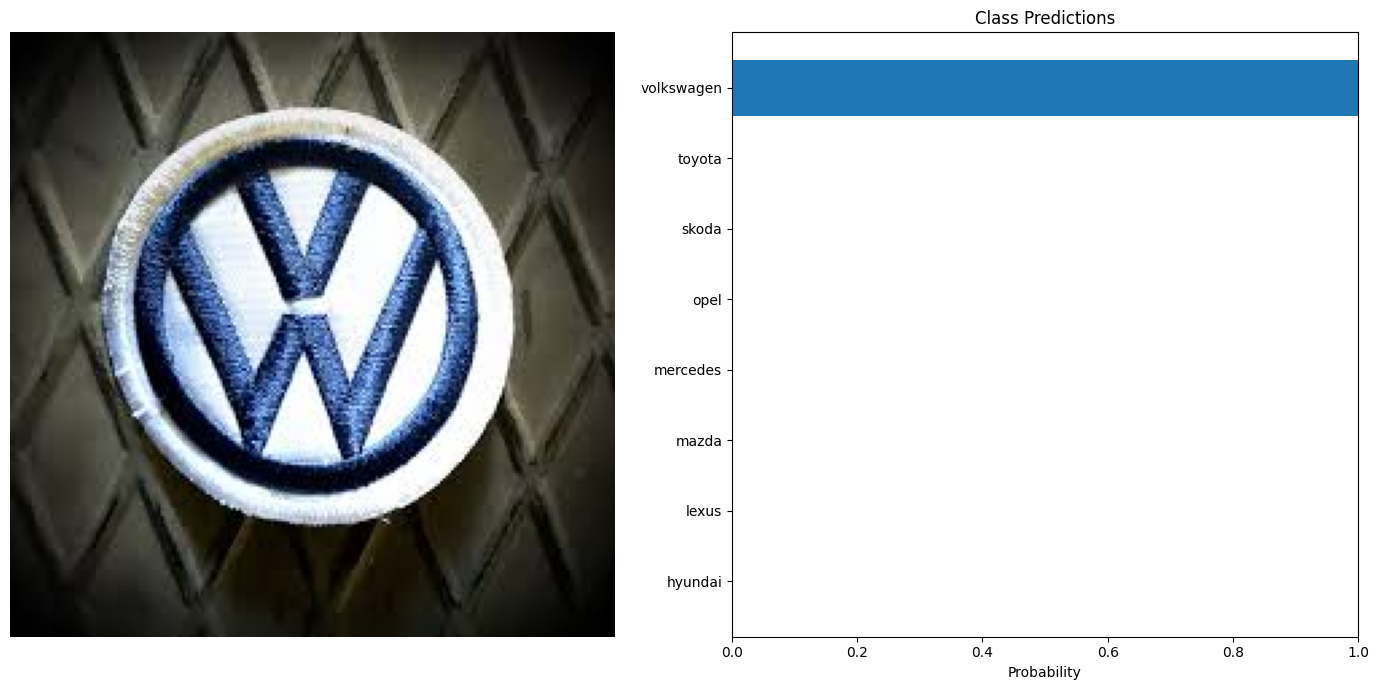

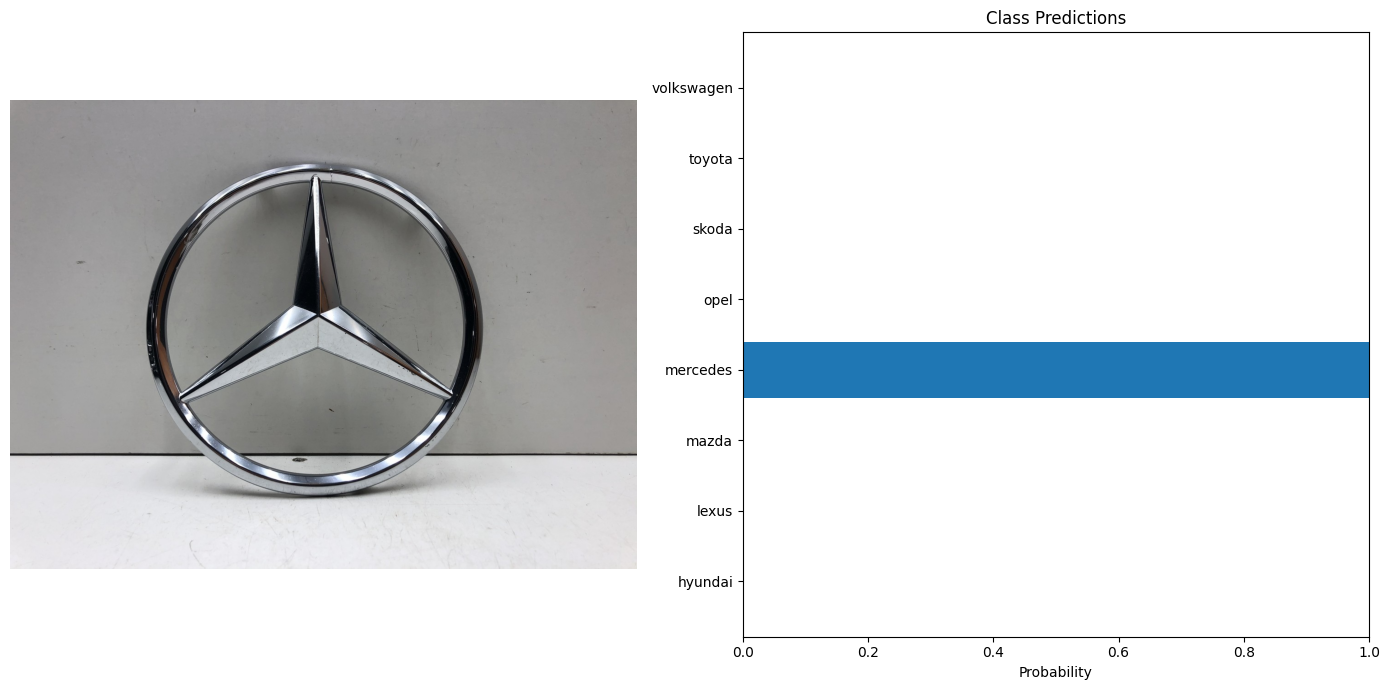

In [34]:
from glob import glob
test_images = glob('/home/jan/.cache/kagglehub/datasets/volkandl/car-brand-logos/versions/1/Car_Brand_Logos/Test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)